In [193]:
import pandas as pd
import warnings

from scipy import stats
from itertools import combinations
from sklearn import preprocessing

In [194]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [195]:
warnings.simplefilter('ignore')

In [196]:
def mirror_d1d2_iter(df):
    for r1 in df.to_dict('records'):
        yield r1
        r2 = r1.copy()
        r2['d1'], r2['d2'] = r2['d2'], r2['d1']
        yield r2

In [197]:
def mirror_d1d2(df):
    return pd.DataFrame(list(mirror_d1d2_iter(df)))

# LSTM all-vs-all probability mass correlations

In [198]:
lstm_pcorr = pd.read_json('data/hl-graph-lstm-pcorr.json', lines=True)
lstm_pcorr = mirror_d1d2(lstm_pcorr)
lstm_pcorr = lstm_pcorr.drop(columns=['kt_p', 'pr_p', 'sp_p'])
lstm_pcorr = lstm_pcorr.set_index(['d1', 'd2'])
lstm_pcorr = lstm_pcorr.add_prefix('lstm_pcorr_')
lstm_pcorr = lstm_pcorr.reset_index()

In [199]:
lstm_pcorr.sort_values('lstm_pcorr_kt', ascending=False).head(10)

,d1,d2,lstm_pcorr_kt,lstm_pcorr_pr,lstm_pcorr_sp
52,bloomberg.com,wsj.com,0.544591,0.244900,0.730285
53,wsj.com,bloomberg.com,0.544591,0.244900,0.730285
59,dailycaller.com,breitbart.com,0.504639,0.235545,0.688357
58,breitbart.com,dailycaller.com,0.504639,0.235545,0.688357
203,wsj.com,nytimes.com,0.489553,0.158381,0.672381
202,nytimes.com,wsj.com,0.489553,0.158381,0.672381
184,msnbc.com,thehill.com,0.478135,0.121547,0.660237
185,thehill.com,msnbc.com,0.478135,0.121547,0.660237
190,npr.org,nytimes.com,0.468058,0.189297,0.645672
191,nytimes.com,npr.org,0.468058,0.189297,0.645672


# LSTM all-vs-all confusion counts

In [200]:
lstm_conf = pd.read_json('data/hl-graph-lstm-confusion-counts.json', lines=True)
lstm_conf = lstm_conf.set_index(['d1', 'd2'])
lstm_conf = lstm_conf.add_prefix('lstm_conf_')
lstm_conf = lstm_conf.reset_index()

In [201]:
lstm_conf.sort_values('lstm_conf_count', ascending=False).head(10)

,d1,d2,lstm_conf_count
197,wsj.com,bloomberg.com,362
72,dailycaller.com,breitbart.com,321
98,foxnews.com,apnews.com,275
27,bloomberg.com,wsj.com,267
177,thehill.com,msnbc.com,267
81,dailycaller.com,thehill.com,253
137,msnbc.com,thehill.com,232
64,cnn.com,msnbc.com,232
150,npr.org,nytimes.com,215
67,cnn.com,thehill.com,210


# LR A-vs-B accuracies

In [256]:
lr_ab_acc = pd.read_json('data/hl-graph-lr-ab-acc.json', lines=True)
lr_ab_acc = mirror_d1d2(lr_ab_acc)

# Use 1-acc, so that high score -> high similarity.
lr_ab_acc['inv_acc'] = 1 - lr_ab_acc.acc
lr_ab_acc = lr_ab_acc.drop(columns=['acc'])

lr_ab_acc = lr_ab_acc.set_index(['d1', 'd2'])
lr_ab_acc = lr_ab_acc.add_prefix('lr_ab_acc_')
lr_ab_acc = lr_ab_acc.reset_index()

In [249]:
lr_ab_acc.sort_values('lr_ab_acc_inv_acc', ascending=False).head(10)

,d1,d2,lr_ab_acc_inv_acc
178,nytimes.com,npr.org,0.337632
179,npr.org,nytimes.com,0.337632
214,sputniknews.com,rt.com,0.328947
215,rt.com,sputniknews.com,0.328947
56,cnn.com,foxnews.com,0.323894
57,foxnews.com,cnn.com,0.323894
243,npr.org,washingtonpost.com,0.321756
242,washingtonpost.com,npr.org,0.321756
27,wsj.com,bloomberg.com,0.314889
26,bloomberg.com,wsj.com,0.314889


# All metrics

In [250]:
df = lstm_pcorr.merge(lstm_conf).merge(lr_ab_acc)

In [251]:
df.sort_values('lstm_conf_count', ascending=False).head(10)

,d1,d2,lstm_pcorr_kt,lstm_pcorr_pr,lstm_pcorr_sp,lstm_conf_count,lr_ab_acc_inv_acc
53,wsj.com,bloomberg.com,0.544591,0.244900,0.730285,362,0.314889
59,dailycaller.com,breitbart.com,0.504639,0.235545,0.688357,321,0.301444
13,foxnews.com,apnews.com,0.240590,0.096741,0.343792,275,0.298502
185,thehill.com,msnbc.com,0.478135,0.121547,0.660237,267,0.274346
52,bloomberg.com,wsj.com,0.544591,0.244900,0.730285,267,0.314889
132,dailycaller.com,thehill.com,0.426649,0.138389,0.597465,253,0.279335
184,msnbc.com,thehill.com,0.478135,0.121547,0.660237,232,0.274346
108,cnn.com,msnbc.com,0.409234,0.152077,0.573168,232,0.256447
190,npr.org,nytimes.com,0.468058,0.189297,0.645672,215,0.337632
114,cnn.com,thehill.com,0.266552,0.052812,0.386499,210,0.277213


Group on `d1`, scale scores with other outlets.

In [252]:
for col in set(df.columns) - {'d1', 'd2', 'label'}:
    df[f'{col}_scaled'] = df.groupby('d1')[col].transform(preprocessing.scale)

In [253]:
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [254]:
df_melted = df.melt(['d1', 'd2', 'label'], [c for c in df.columns if c.endswith('_scaled')])

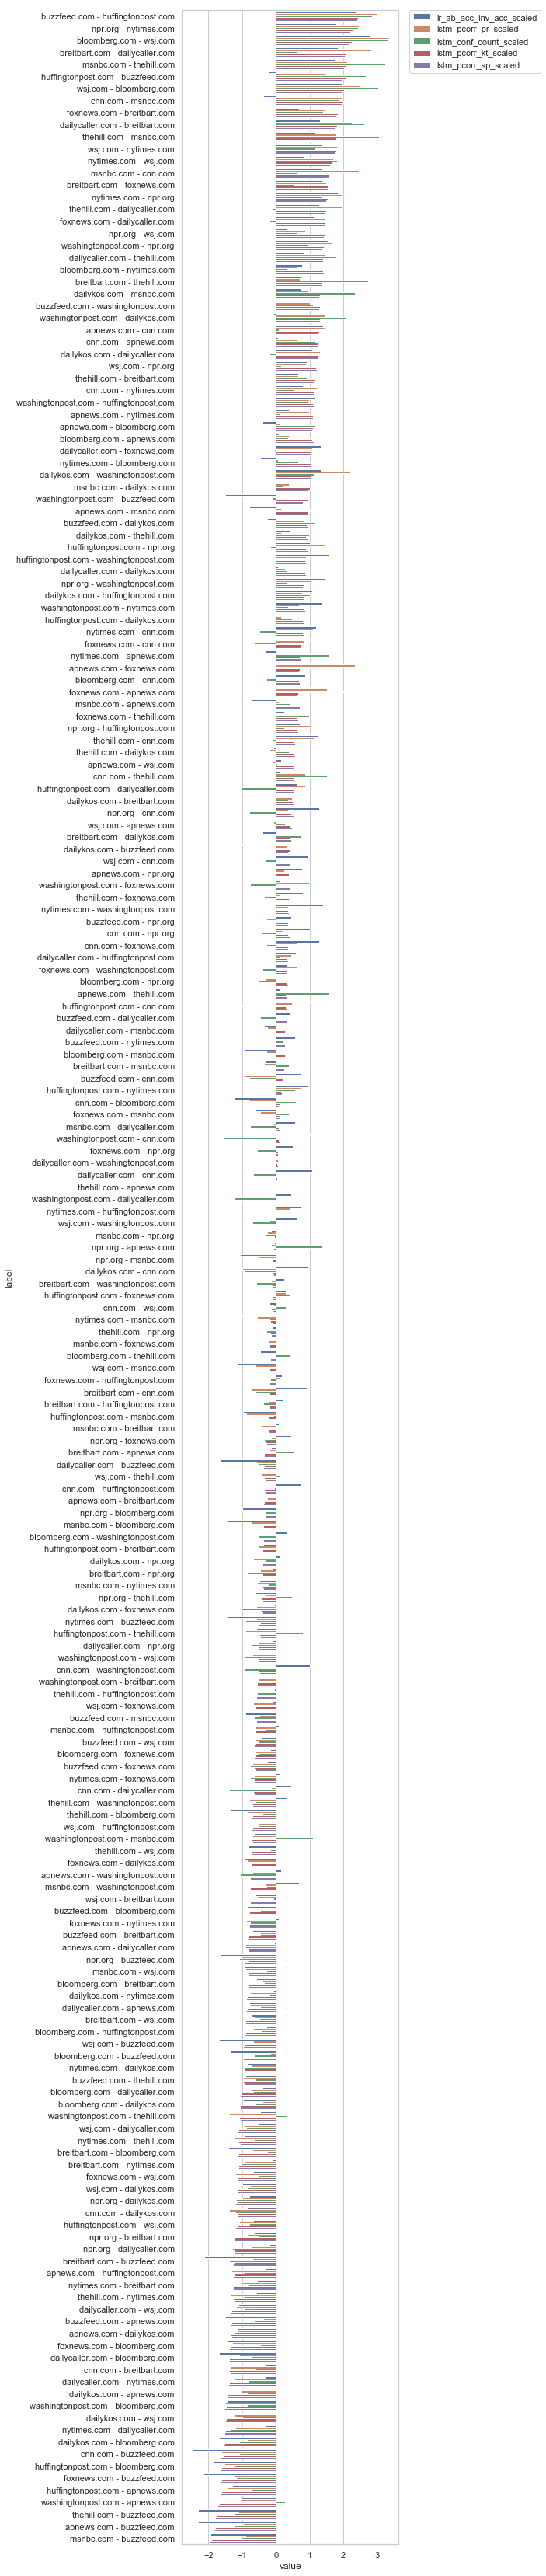

In [261]:
order = df.sort_values('lstm_pcorr_kt_scaled', ascending=False).label
plt.figure(figsize=(5,60))
ax = sns.barplot(x='value', y='label', data=df_melted, hue='variable', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)